## FIFA (Fruitball Association) 水果杯足球赛开打了，你有办法预测比赛的胜负吗

> 本次资料集搜集了`一百万`场比赛的胜负数据，以及该场比赛`两队的阵势`，以及每个位置`球员的能力值`


***期望各位数据科学家们，找到其中的蛛丝马迹，掌握比赛的胜负！***

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import warnings
import seaborn as sns
import collections
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
df = pd.read_csv('./data/totalScore.csv')

### 观察数据

* 每队有p0-p13不同位置的球员
* 有胜负的数据、也有两队分数分数的数据

In [4]:
df.head()

,t1form,t1p0,t1p1,t1p2,t1p3,t1p4,t1p5,t1p6,t1p7,t1p8,...,t2p7,t2p8,t2p9,t2p10,t2p11,t2p12,t2p13,t1Score,t2Score,winner
0,3-5-2,6.0,8.2,6.9,6.6,9.9,5.1,5.7,6.4,5.2,...,6.7,8.4,5.6,7.2,8.0,8.9,6.8,1,2,2
1,3-4-3,7.0,7.3,8.2,5.2,7.3,9.9,5.9,5.5,7.2,...,6.3,7.4,9.0,8.9,6.9,5.5,8.1,2,4,2
2,4-5-1,5.4,9.8,7.2,9.2,6.9,8.3,7.8,8.4,6.4,...,9.5,7.5,9.2,9.2,6.7,9.9,5.1,0,1,2
3,4-3-3,9.6,9.8,8.1,9.3,6.3,7.7,5.4,5.7,6.1,...,7.2,9.7,7.7,7.2,9.4,6.5,9.3,2,4,2
4,3-6-1,7.2,6.2,7.8,7.5,7.8,8.9,5.4,7.3,7.4,...,6.8,9.4,6.9,7.8,6.6,6.1,6.0,4,6,2


In [5]:
df.columns

Index(['t1form', 't1p0', 't1p1', 't1p2', 't1p3', 't1p4', 't1p5', 't1p6',
       't1p7', 't1p8', 't1p9', 't1p10', 't1p11', 't1p12', 't1p13', 't2form',
       't2p0', 't2p1', 't2p2', 't2p3', 't2p4', 't2p5', 't2p6', 't2p7', 't2p8',
       't2p9', 't2p10', 't2p11', 't2p12', 't2p13', 't1Score', 't2Score',
       'winner'],
      dtype='object')

### 栏位说明

* `t1` 代表第一队， `t2` 代表第二队
* `p0 - p13` 代表球场上的 13 名球员，位置先不透露
* `t1Score` 是第一队分数 `t2Score` 是第二队分数
* `winner` 1 代表第一队赢，2 代表第二队赢

In [6]:
print(f'一共有 {df.shape[0]} 场比赛资料，包含 {df.shape[1]} 个栏位 ')

一共有 1000000 场比赛资料，包含 33 个栏位 


### 首先想看看分数的差距，跟特征的相关性，先加入差距栏位

In [7]:
df['diff'] = df.apply(lambda row: abs(row['t1Score'] - row['t2Score']), axis=1)

### [简化资料] 赛事结果是相对的，试试看先只考虑相对位置能力值的差距

In [8]:
df_new = pd.DataFrame()

for i in range(0, 14):
    t1_col = 't1p' + str(i)
    t2_col = 't2p' + str(i)
    df_new['p' + str(i)] = df[t1_col] - df[t2_col]
    
df_new['score'] = df['t1Score'] - df['t2Score']
df_new['win'] = [1 if x == 1 else 2 for x in df['winner']] 

In [9]:
df_new.head()

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,score,win
0,0.2,1.9,-2.4,-3.3,3.6,-4.3,-1.1,-0.3,-3.2,2.8,1.1,0.0,-0.3,1.7,-1,2
1,-1.1,-0.2,-0.8,-1.5,1.8,0.5,-0.7,-0.8,-0.2,-2.3,-2.7,1.1,1.4,1.3,-2,2
2,-3.6,4.1,-0.5,-0.1,0.3,2.1,-0.5,-1.1,-1.1,-3.7,-1.7,2.3,-4.9,4.2,-1,2
3,0.8,4.7,0.6,0.6,1.1,1.6,-2.2,-1.5,-3.6,-1.5,2.2,-2.0,0.4,-3.4,-2,2
4,-2.4,-1.2,0.6,-0.1,0.0,1.7,-4.4,0.5,-2.0,-0.4,0.7,-1.5,-0.7,2.7,-2,2


In [10]:
result = dict(collections.Counter(df_new['win']))
print(f'第一队赢了 {result[1]} 次，输了 {result[2]} 次')

第一队赢了 499792 次，输了 500208 次


In [11]:
train_features = list(df_new.columns[:-2])

In [12]:
X = df_new.iloc[:,:-2].values
y = df_new[['win']].values

### xgboost 是分类演算法神器，不确定选什么模型就先套这个吧！

* 简单的说：先建一颗决策树，检讨预测不足的地方 -> 再建一棵树 -> 一直到建了k颗树
* 集合 k 颗树的智慧一起预测，打团体战的概念！
* 在许多比赛里，取得统治级的表现

In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

### 切分训练集以及测试集

In [14]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3)

In [15]:
model = XGBClassifier(nthread=-1)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

### 有兴趣的同学，可以多多研究这些参数的意义！

In [16]:
test_pred = model.predict(X_test)
acc = metrics.accuracy_score(y_test, test_pred)
print('牛刀小试一下，准确率:', acc)

牛刀小试一下，准确率: 0.65328


## [动动脑] 学习机器学习不能知道准确性偏误的可怕

> 某种疾病，每一千个患者才出现一名阳性反应，如今导入一个号称准确率 99.9% 的神奇模型，请问该怎么做？

Ans. 全部猜阴性就好！

In [17]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, test_pred).ravel()

print(f'第一队真的赢了，模型也猜对的有 {tp} 次')
print(f'第一队真的赢了，模型猜输的有 {fn} 次')
print(f'第一队真的输了，模型也猜对的有 {tn} 次')
print(f'第一队真的输了，模型猜赢的有 {fp} 次')

第一队真的赢了，模型也猜对的有 98409 次
第一队真的赢了，模型猜输的有 51430 次
第一队真的输了，模型也猜对的有 97575 次
第一队真的输了，模型猜赢的有 52586 次


### 如果把阵型考虑进去呢？

In [18]:
df_new = pd.concat([df_new, pd.get_dummies(df[['t1form']],
                                  prefix='t1form',dummy_na=True)], axis=1)
df_new = pd.concat([df_new,pd.get_dummies(df[['t2form']],
                                  prefix='t2form',dummy_na=True)], axis=1)

df_new = df_new.drop(['t2form_nan','t1form_nan'], axis=1)

### 栏位突然变这么多！

In [19]:
df_new.columns

Index(['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10',
       'p11', 'p12', 'p13', 'score', 'win', 't1form_3-4-3', 't1form_3-5-2',
       't1form_3-6-1', 't1form_4-2-2-2', 't1form_4-2-3-1', 't1form_4-3-2-1',
       't1form_4-3-3', 't1form_4-4-2', 't1form_4-5-1', 't1form_5-3-2',
       't1form_5-4-1', 't2form_3-4-3', 't2form_3-5-2', 't2form_3-6-1',
       't2form_4-2-2-2', 't2form_4-2-3-1', 't2form_4-3-2-1', 't2form_4-3-3',
       't2form_4-4-2', 't2form_4-5-1', 't2form_5-3-2', 't2form_5-4-1'],
      dtype='object')

### [动动脑] 如果给模型这样的训练资料，会有什么重大问题

* `team1_type` 代表第一队的阵势
* `team2_type` 代表第二队的阵势


| p0 | p1 | p2 | p3 | team1_type | team2_type |
|---|---|---|---|---|---|
| 0.2 | 2.1 | -0.1 | 4.1 | 1 | 2 |
| 1.3 | 0.5 | 3.0 | 2.5 | 3 | 1 |
| 4.1 | 0.8 | 2.3 | -1.1 | 2 | 3 |


Ans. 模型并不知道 `team1_type` 以及 `team2_type` 是类别型的资料，会认为 1, 2, 3, ... 之间数字大小是有距离关系的！

   ==> 透过 `get_dummies` 转换成，多栏位的 `类别型资料`，专业的术语称作为 `one-hot` 编码
   
***如以下所见，全部只有 0 和 1***

In [20]:
df_new[['t1form_3-6-1','t1form_3-4-3','t1form_3-5-2','t1form_4-2-2-2','t1form_4-3-3','t1form_4-4-2']].head()

,t1form_3-6-1,t1form_3-4-3,t1form_3-5-2,t1form_4-2-2-2,t1form_4-3-3,t1form_4-4-2
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,1,0
4,1,0,0,0,0,0


### 取得目前所有可供训练的属性

In [21]:
for col in df_new.columns:
    if col.startswith('t'):
        train_features.append(col)
        
print(train_features)

['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 't1form_3-4-3', 't1form_3-5-2', 't1form_3-6-1', 't1form_4-2-2-2', 't1form_4-2-3-1', 't1form_4-3-2-1', 't1form_4-3-3', 't1form_4-4-2', 't1form_4-5-1', 't1form_5-3-2', 't1form_5-4-1', 't2form_3-4-3', 't2form_3-5-2', 't2form_3-6-1', 't2form_4-2-2-2', 't2form_4-2-3-1', 't2form_4-3-2-1', 't2form_4-3-3', 't2form_4-4-2', 't2form_4-5-1', 't2form_5-3-2', 't2form_5-4-1']


### 再做一次训练看看

In [22]:
X = df_new[train_features].values
y = df_new[['win']].values

In [23]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3)

In [24]:
model_addForm = XGBClassifier(nthread=-1)
model_addForm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [25]:
test_pred = model_addForm.predict(X_test)
acc = metrics.accuracy_score(y_test, test_pred)
print('准确率:', acc)

准确率: 0.68978


### 观察一下栏位重要性

In [26]:
importances_df = pd.DataFrame()

for value, name in zip(model_addForm.feature_importances_, train_features):
    importances_df = importances_df.append({'feature': name, 'value': value}, 
                                           ignore_index=True)

In [27]:
importances_df = importances_df.sort_values(['value'],
                    ascending=[False]).reset_index(drop=True)

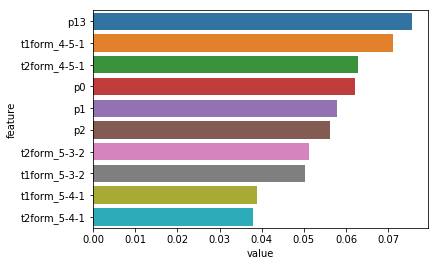

In [28]:
ax = sns.barplot(x="value", y="feature", data=importances_df.iloc[0:10])

## 加入提示

* 球员位置分配： p0-p2 前锋、p3-p7 中场、p8-p12 后卫、p13 守门员

In [29]:
result_4_5_1  = dict(collections.Counter(df_new[df_new['t1form_4-5-1'] == 1]['win']))

print(f'当第一队摆出 `4-5-1` 阵形时，赢了 {result_4_5_1[1]} 场，输了 {result_4_5_1[2]} 场')

result_5_3_2  = dict(collections.Counter(df_new[df_new['t1form_5-3-2'] == 1]['win']))

print(f'当第一队摆出 `5-3-2` 阵形时，赢了 {result_5_3_2[1]} 场，输了 {result_5_3_2[2]} 场')

当第一队摆出 `4-5-1` 阵形时，赢了 28041 场，输了 62825 场
当第一队摆出 `5-3-2` 阵形时，赢了 59759 场，输了 31157 场


### 原来在这样的阵型里，前锋的能力左右了比赛的局势！

In [30]:
p0_w, p1_w, p2_w = df_new[(df_new['win'] == 1) & (df_new['t1form_4-5-1'] == 1)][['p0','p1','p2']].mean()
p0_l, p1_l, p2_l = df_new[(df_new['win'] == 2) & (df_new['t1form_4-5-1'] == 1)][['p0','p1','p2']].mean()

print(f'在摆出 4-5-1 阵形出赛的情况下：')
print(f'\t第一队胜利时前锋能力值平均胜过对手:\
      \n\t{p0_w}, {p1_w}, {p2_w}')
print(f'\t第一队输球时前锋能力值平均输给对手:\
      \n\t{p0_l}, {p1_l}, {p2_l}')

在摆出 4-5-1 阵形出赛的情况下：
	第一队胜利时前锋能力值平均胜过对手:      
	0.46475874612175067, 0.4481330908312806, 0.4537284690274964
	第一队输球时前锋能力值平均输给对手:      
	-0.20159172304019116, -0.19831754874651944, -0.19460724233983245


### 精通胜利之道

> 在这份资料集里，摆上强力前锋是王道啊！

> 好的守门员，让你无后顾之忧

### 资料观察：当两队限制在同一阵形时，每个位置球员重要性是否有差异？

In [31]:
form_type = '4-5-1'

df_forward = df_new[(df_new['t1form_'+form_type]==1) & (df_new['t2form_'+form_type]==1)]\
    [['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'win']]

In [32]:
df_forward['win'] = df_forward['win'].astype('category')
df_forward['win'].cat.categories = [2,1]
df_forward['win'] = df_forward['win'].astype('float')

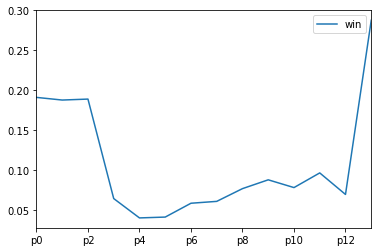

In [33]:
corr = df_forward.corr()
corr[['win']].drop(['win'],axis=0).plot()

In [34]:
form_type = '3-5-2'  

df_guard = df_new[(df_new['t1form_'+form_type]==1) & (df_new['t2form_'+form_type]==1)]\
    [['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'win']]

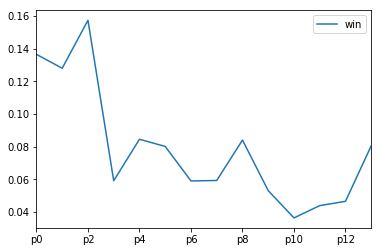

In [35]:
df_guard['win'] = df_guard['win'].astype('category')
df_guard['win'].cat.categories = [2,1]
df_guard['win'] = df_guard['win'].astype('float')
corr = df_guard.corr()
corr[['win']].drop(['win'],axis=0).plot()

### 已经知道栏位意义了，为了简化资料，把同位置合并

In [36]:
df_group = pd.DataFrame()

## 把 13 个位置合并成： f(前锋), m(中场), b(后卫), g(守门员)
df_group['t1_f'] = (df['t1p0'] + df['t1p1'] + df['t1p2']) / 3
df_group['t1_m'] = (df['t1p3'] + df['t1p4'] + df['t1p5'] + df['t1p6'] + df['t1p7']) / 5
df_group['t1_b'] = (df['t1p8'] + df['t1p9'] + df['t1p10'] + df['t1p11'] + df['t1p12']) / 5
df_group['t1_g'] = df['t1p13']

df_group['t2_f'] = (df['t2p0'] + df['t2p1'] + df['t2p2']) / 3
df_group['t2_m'] = (df['t2p3'] + df['t2p4'] + df['t2p5'] + df['t2p6'] + df['t2p7']) / 5
df_group['t2_b'] = (df['t2p8'] + df['t2p9'] + df['t2p10'] + df['t2p11'] + df['t2p12']) / 5
df_group['t2_g'] = df['t2p13']

## 加入阵形资讯
df_group = pd.concat([df_group, pd.get_dummies(df[['t1form']],
                                  prefix='t1form',dummy_na=True)], axis=1)
df_group = pd.concat([df_group,pd.get_dummies(df[['t2form']],
                                  prefix='t2form',dummy_na=True)], axis=1)


df_group['win'] = df_new['win']

positions = ['t1_f', 't1_m', 't1_b', 't1_g', 't2_f', 't2_m', 't2_b', 't2_g',
             't1form_3-4-3', 't1form_3-5-2', 't1form_3-6-1', 't1form_4-2-2-2', 
             't1form_4-2-3-1', 't1form_4-3-2-1', 't1form_4-3-3', 't1form_4-4-2', 
             't1form_4-5-1', 't1form_5-3-2', 't1form_5-4-1', 't2form_3-4-3', 
             't2form_3-5-2', 't2form_3-6-1', 't2form_4-2-2-2', 't2form_4-2-3-1', 
             't2form_4-3-2-1', 't2form_4-3-3', 't2form_4-4-2', 't2form_4-5-1', 
             't2form_5-3-2', 't2form_5-4-1']

In [37]:
X = df_group[positions].values
y = df_group[['win']].values

In [38]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3)

model_position = XGBClassifier(nthread=-1)
model_position.fit(X_train, y_train)
test_pred = model_position.predict(X_test)

### 栏位减少，准确率甚至还比原本好一点

In [39]:
acc = metrics.accuracy_score(y_test, test_pred)
print('准确率:', acc)

准确率: 0.6968633333333333


In [40]:
with open('fifa_model.pickle', 'wb') as handle:
    pickle.dump(model_position, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
with open('fifa_model.pickle', 'rb') as handle:
    model = pickle.load(handle)

## 来预测对战胜负吧！

In [42]:
form_list = ['3-4-3', '3-5-2', '3-6-1', '4-2-2-2', 
             '4-2-3-1', '4-3-2-1', '4-3-3', '4-4-2', 
             '4-5-1', '5-3-2', '5-4-1']
position_list = ['f', 'm', 'b', 'g']

In [44]:
def predict(team_1, team_2):
    feature_len = (len(position_list) + len(form_list)) * 2
    feature = [0] * feature_len
    
    ## 填入两队的各位置能力值
    for idx, pos in enumerate(position_list):
        feature[idx] = team_1[position_list[idx]]
        feature[idx+4] = team_2[position_list[idx]]
        
    ## 填入两队的阵形安排
    form_id_1 = form_list.index(team_1['form']) + len(position_list)*2
    form_id_2 = form_list.index(team_2['form']) + len(position_list)*2 + len(form_list)
    feature[form_id_1] = 1
    feature[form_id_2] = 1
    
    ## 回传预测结果
    return model.predict_proba(np.asarray(feature).reshape(1, feature_len))[0]
    

## 两队能力值及阵形    
team_1 = {'f': 2.27, 'm': 6.76, 'b': 7.34, 'g': 10.0, 'form': '4-3-3'}
team_2 = {'f': 2.48, 'm': 5.23, 'b': 3.34, 'g': 8.0, 'form': '4-3-3'}
result = predict(team_1, team_2)

win_team = 1
if result[0] < result[1]:
    win_team = 2

print(f'比赛结果：team{win_team} 获胜！获胜机率是：{result[win_team - 1]}')

比赛结果：team1 获胜！获胜机率是：0.5906428098678589


### [试试看] 如果你是 team2 的教练，该这样束手就擒吗？

In [ ]:
### 你会怎么做呢？



In [45]:
win_form = ''
win_prob = -100
for form in form_list:
    team_2['form'] = form
    prob = predict(team_1, team_2)[1]
    if  prob > win_prob:
        win_form = form
        win_prob = prob
    
print(f'原來靠 {win_form} 陣形，就可以逆轉戰局了啊！！勝率為：{win_prob}')

原來靠 5-3-2 陣形，就可以逆轉戰局了啊！！勝率為：0.5900010466575623


## 20 分钟想一个优化的方式，建立一个自创的模型

* 创造一个新的栏位，再做训练，并观察结果
* 你有办法预测胜分差吗？ (是哪一种问题？分类、回归、聚类)
    * 参考范例：https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* 模拟4个球队数据，打一个小小世界杯，并观察对战顺序改变，结果是否不同？